In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import dateutil

## Load and preprocess data

In [2]:
t_test = dateutil.parser.isoparse('2020-11-16')
data_300s = pd.read_csv('Data/300S.csv.gz', compression='gzip', parse_dates=['Time'])[lambda x: x['Time'] >= t_test]
data_200s = pd.read_csv('Data/200S.csv.gz', compression='gzip', parse_dates=['Time'])[lambda x: x['Time'] >= t_test]

In [3]:
lns_300s = ['6:8','8:9', '9:11']
connection_data_300s = pd.DataFrame({
    'DepartureTime': data_300s.groupby(['JourneyRef', 'LinkRef'])['Time'].first().unstack(1)[lns_300s[0]],    
    'ArrivalTime': (data_300s.groupby(['JourneyRef', 'LinkRef'])['Time'].first().unstack(1)[lns_300s[-1]] + pd.to_timedelta(data_300s.groupby(['JourneyRef', 'LinkRef'])['LinkTravelTime'].first().unstack(1)[lns_300s[-1]].dropna(), unit='s')),
    'MultiLinkTravelTime': data_300s.groupby(['JourneyRef', 'LinkRef'])['LinkTravelTime'].first().unstack(1)[lns_300s].dropna().sum(axis=1),
    'PreConnectionDelay': data_300s.groupby(['JourneyRef', 'LinkRef'])['LinkEnterDelay'].first().unstack(1)[lns_300s[-1]],
    'PostConnectionDelay': data_300s.groupby(['JourneyRef', 'LinkRef'])['LinkEnterDelay'].first().unstack(1)['11:12'],
    'MatchTime': data_300s.groupby(['JourneyRef', 'LinkRef'])['Time'].first().unstack(1)['11:12'] - pd.to_timedelta(data_300s.groupby(['JourneyRef', 'LinkRef'])['LinkEnterDelay'].first().unstack(1)['11:12'], unit='s')
}).dropna().reset_index().rename(columns={'index': 'JourneyRef'}).set_index('MatchTime', drop=False).sort_index()
connection_data_300s['ConnectionDelay'] = connection_data_300s['PostConnectionDelay'] - connection_data_300s['PreConnectionDelay']

In [4]:
lns_200s = ['52396:11']
connection_data_200s = pd.DataFrame({
    'DepartureTime': data_200s.groupby(['JourneyRef', 'LinkRef'])['Time'].first().unstack(1)[lns_200s[0]],    
    'ArrivalTime': (data_200s.groupby(['JourneyRef', 'LinkRef'])['Time'].first().unstack(1)[lns_200s[-1]] + pd.to_timedelta(data_200s.groupby(['JourneyRef', 'LinkRef'])['LinkTravelTime'].first().unstack(1)[lns_200s[-1]].dropna(), unit='s')),
    'MultiLinkTravelTime': data_200s.groupby(['JourneyRef', 'LinkRef'])['LinkTravelTime'].first().unstack(1)[lns_200s].dropna().sum(axis=1),
    'PreConnectionDelay': data_200s.groupby(['JourneyRef', 'LinkRef'])['LinkEnterDelay'].first().unstack(1)[lns_200s[-1]],
    'PostConnectionDelay': data_200s.groupby(['JourneyRef', 'LinkRef'])['LinkEnterDelay'].first().unstack(1)['11:12'],
    'MatchTime': data_200s.groupby(['JourneyRef', 'LinkRef'])['Time'].first().unstack(1)['11:12'] - pd.to_timedelta(data_200s.groupby(['JourneyRef', 'LinkRef'])['LinkEnterDelay'].first().unstack(1)['11:12'], unit='s')
}).dropna().reset_index().rename(columns={'index': 'JourneyRef'}).set_index('MatchTime', drop=False).sort_index()
connection_data_200s['ConnectionDelay'] = connection_data_200s['PostConnectionDelay'] - connection_data_200s['PreConnectionDelay']

In [5]:
(connection_data_300s['PostConnectionDelay'] - connection_data_300s['PreConnectionDelay']).mean()

76.05913570887036

In [6]:
(connection_data_200s['PostConnectionDelay'] - connection_data_200s['PreConnectionDelay']).mean()

57.36015325670498

### Match scheduled connections

In [7]:
t_tol = pd.to_timedelta('5min')
connection_data = pd.merge_asof(connection_data_200s, connection_data_300s, left_index=True, right_index=True, suffixes=('_200S', '_300S'), tolerance=t_tol).dropna()
connection_data[['MatchTime_300S', 'MatchTime_200S', 'ArrivalTime_200S', 'ArrivalTime_300S', 'ConnectionDelay_200S']].head(4)

,MatchTime_300S,MatchTime_200S,ArrivalTime_200S,ArrivalTime_300S,ConnectionDelay_200S
MatchTime,,,,,
2020-11-16 06:17:00,2020-11-16 06:14:00,2020-11-16 06:17:00,2020-11-16 06:18:20,2020-11-16 06:16:13,82.0
2020-11-16 06:37:00,2020-11-16 06:37:00,2020-11-16 06:37:00,2020-11-16 06:36:51,2020-11-16 06:39:20,-12.0
2020-11-16 06:58:00,2020-11-16 06:58:00,2020-11-16 06:58:00,2020-11-16 06:58:17,2020-11-16 07:01:41,29.0
2020-11-16 07:10:00,2020-11-16 07:09:00,2020-11-16 07:10:00,2020-11-16 07:10:16,2020-11-16 07:16:09,30.0


In [8]:
transfer_time = pd.to_timedelta('1min')
connection_data.loc[lambda x: x['ArrivalTime_200S'] + pd.to_timedelta(x['ConnectionDelay_200S'], unit='s') < x['ArrivalTime_300S'] + transfer_time, 'Connection State'] = 'Broken'

In [9]:
connection_data.loc[lambda x: x['ArrivalTime_200S'] + pd.to_timedelta(x['ConnectionDelay_200S'], unit='s') > x['ArrivalTime_300S'] + transfer_time, 'Connection State'] = 'Kept'

In [10]:
connection_data['Connection State'].value_counts()

Broken    253
Kept      193
Name: Connection State, dtype: int64

In [13]:
connection_data.groupby('Connection State')['ConnectionDelay_200S'].mean()

Connection State
Broken    45.671937
Kept      75.538860
Name: ConnectionDelay_200S, dtype: float64

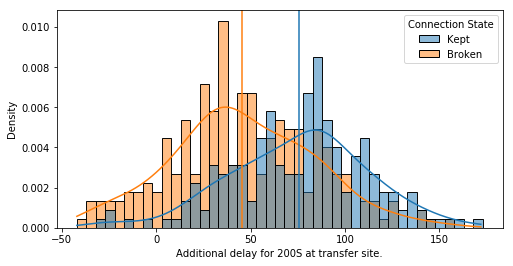

In [11]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=1)
sns.histplot(connection_data, x='ConnectionDelay_200S', hue='Connection State', stat='density', kde=True, binwidth=5, color='C0', multiple='layer', shrink=1)
ax.set_xlabel('Additional delay for 200S at transfer site.')
ax.axvline(connection_data.groupby('Connection State')['ConnectionDelay_200S'].mean()['Kept'])
ax.axvline(connection_data.groupby('Connection State')['ConnectionDelay_200S'].mean()['Broken'], color='C1')
plt.savefig('additional-delay-200S.pdf', bbox_inches='tight')

In [12]:
connection_data.to_csv('Data/300S_200S_Connections.csv.gz')